# HMM y CRF con dataset real de NER en español

### José Pablo Kiesling Lange

In [20]:
from datasets import load_dataset

import numpy as np

## Ejercicio 1 — HMM: inferencia de matrices desde SPACCC

In [2]:
dataset = load_dataset("IEETA/SPACCC-Spanish-NER")

In [3]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [4]:
train_dataset[:5]

{'filename': ['S0004-06142005000500011-1',
  'S0004-06142005000500011-1',
  'S0004-06142005000500011-1',
  'S0004-06142005000500011-1',
  'S0004-06142005000500011-1'],
 'ann_id': [0, 1, 2, 3, 4],
 'label': ['DISEASE', 'DISEASE', 'PROCEDURE', 'DISEASE', 'DISEASE'],
 'start_span': [50, 158, 192, 207, 280],
 'end_span': [73, 190, 278, 230, 305],
 'text': ['alergias medicamentosas',
  'fracturas vertebrales y costales',
  'intervenido de enfermedad de Dupuytren en mano derecha y by-pass iliofemoral izquierdo',
  'enfermedad de Dupuytren',
  'Diabetes Mellitus tipo II']}

El libro dice:

> In BIO tagging we label any token that begins a span of interest with the label B, tokens that occur inside a span are tagged with an I, and any tokens outside of any span of interest are labeled O.

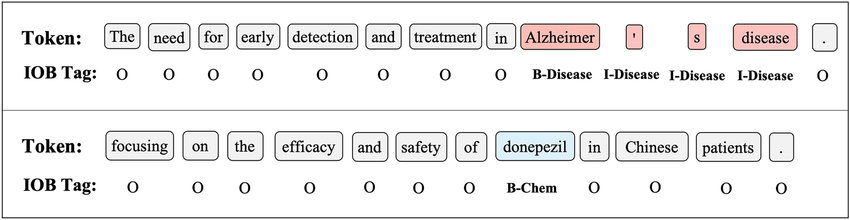

Como se puede ver, las etiquetas no están en formato BIO token por token, sino como segmentos de texto marcados. Para entrenar modelos de secuencias como HMM o CRF, es necesario un paso de preprocesamiento donde cada oración se tokenice y se asignen etiquetas BIO.

### Preprocesamiento

In [5]:
def tag_sentence_bio(sentence, label):
    tags = [f"B-{label}"]
    for token in sentence[1:]:
        tags.append(f"I-{label}")
    return tags

In [6]:
def tokenize_sentence(sentence):
    tokens = sentence.split()
    return tokens

In [7]:
types_of_tags = sorted(set(example["label"] for example in train_dataset))

Dado que todas las palabras del dataset están taggeadas, no hay `outside of span` en las oraciones, por lo que no se tomará en cuenta.

In [8]:
BIO = ["B", "I"]

In [9]:
dict_labels_order = [f"{bio}-{label}" for label in types_of_tags for bio in BIO]
dict_labels = {tag: i for i, tag in enumerate(dict_labels_order)}

In [10]:
unique_words = set(word for sentence in train_dataset for word in tokenize_sentence(sentence["text"]))
vocab = ["<UNK>"] + sorted(unique_words)
dict_tokens = {token: i for i, token in enumerate(vocab)}

In [11]:
def map_sentence_to_integer_labels(sentence):
    sentence_text = sentence["text"]
    sentence_label = sentence["label"]
    tags = tag_sentence_bio(tokenize_sentence(sentence_text), sentence_label)
    tokens = tokenize_sentence(sentence_text)
    return {
        "sentence": sentence_text,
        "tokens": [dict_tokens.get(token, dict_tokens["<UNK>"]) for token in tokens],
        "labels": [dict_labels[tag] for tag in tags]
    }


In [12]:
test_sentence = dataset["train"][0]

In [13]:
mapped_sentence = map_sentence_to_integer_labels(test_sentence)

In [14]:
test_sentence["text"]

'alergias medicamentosas'

In [15]:
mapped_sentence

{'sentence': 'alergias medicamentosas',
 'tokens': [3342, 10117],
 'labels': [2, 3]}

In [16]:
mapped_sentence_train = {}
mapped_sentence_test = {}

In [17]:
for sentence in train_dataset:
    mapped_sentence_train[(sentence["filename"], sentence["ann_id"])] = map_sentence_to_integer_labels(sentence)

for sentence in test_dataset:
    mapped_sentence_test[(sentence["filename"], sentence["ann_id"])] = map_sentence_to_integer_labels(sentence)

In [18]:
mapped_sentence = list(mapped_sentence_train.items())

In [19]:
mapped_sentence[:5]

[(('S0004-06142005000500011-1', 0),
  {'sentence': 'alergias medicamentosas',
   'tokens': [3342, 10117],
   'labels': [2, 3]}),
 (('S0004-06142005000500011-1', 1),
  {'sentence': 'fracturas vertebrales y costales',
   'tokens': [7794, 14723, 14877, 5652],
   'labels': [2, 3, 3, 3]}),
 (('S0004-06142005000500011-1', 2),
  {'sentence': 'intervenido de enfermedad de Dupuytren en mano derecha y by-pass iliofemoral izquierdo',
   'tokens': [9252,
    5895,
    6794,
    5895,
    1319,
    6719,
    9991,
    6024,
    14877,
    4576,
    8835,
    9457],
   'labels': [4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]}),
 (('S0004-06142005000500011-1', 3),
  {'sentence': 'enfermedad de Dupuytren',
   'tokens': [6794, 5895, 1319],
   'labels': [2, 3, 3]}),
 (('S0004-06142005000500011-1', 4),
  {'sentence': 'Diabetes Mellitus tipo II',
   'tokens': [1295, 2097, 14004, 1793],
   'labels': [2, 3, 3, 3]})]

## Calcular las matrices 

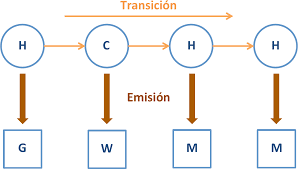

In [44]:
num_tags = len(dict_labels)
num_tokens = len(dict_tokens)

### Matriz de transición

In [40]:
transition_count = [
    [0 for _ in range(num_tags)] for _ in range(num_tags)
]

In [41]:
for sentence in mapped_sentence_train.values():
    labels = sentence["labels"]
    for t in range(len(labels) - 1):
        transition_count[labels[t]][labels[t + 1]] += 1

In [42]:
transition_matrix = transition_count / np.sum(transition_count, axis=1, keepdims=True)

In [43]:
transition_matrix

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### Matriz de emisión

In [49]:
emision_count = [
    [0 for _ in range(num_tokens)] for _ in range(num_tags)
]

In [50]:
for sentence in mapped_sentence_train.values():
    labels = sentence["labels"]
    tokens = sentence["tokens"]
    for t in range(len(labels)):
        emision_count[labels[t]][tokens[t]] += 1

In [51]:
emision_matrix = emision_count / np.sum(emision_count, axis=1, keepdims=True)

In [52]:
emision_matrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.09998900e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.73692078e-05, 0.00000000e+00, 0.00000000e+00]],
      shape=(10, 15017))